# Imports

In [1]:
import json
import esppy
import threading
import time
import websocket
from random import randint
import numpy as np
import base64
import cv2
from matplotlib import pyplot as plt

# Build SAS ESP Pipeline 

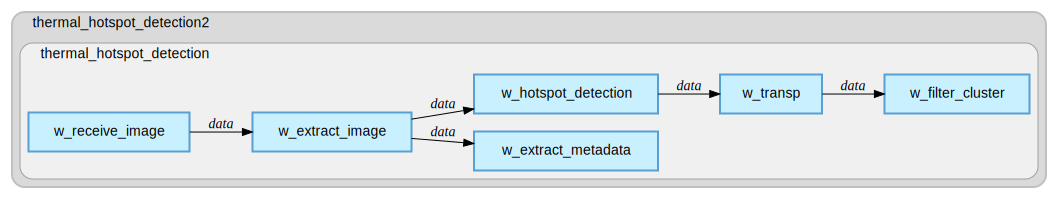

In [2]:
esp = esppy.ESP(hostname='http://localhost:9900')
# CAS data storage paths
hotspots_csv_path = '/data/notebooks/VA_embedded/hotspot_detection/CSV_tables/hotspots.csv' #'/data/nfs/cas/hotspots.csv'
metadata_csv_path = '/data/notebooks/VA_embedded/hotspot_detection/CSV_tables/metadata.csv' #'/data/nfs/cas/metadata.csv'
file_conn_hotspots = esppy.connectors.FileSubscriber(fsname=hotspots_csv_path, fstype='csv', snapshot=True, header='full')
file_conn_metadata = esppy.connectors.FileSubscriber(fsname=metadata_csv_path, fstype='csv', snapshot=True, header='full')
esp_project = esp.create_project('thermal_hotspot_detection2', 
                                 n_threads=8, 
                                 pubsub='manual')
esp_project.add_continuous_query('thermal_hotspot_detection')
esp_project

### receive image as base64
w_image = esp.SourceWindow(name='w_receive_image',
                           schema=('id*:int64', 'customer:string', 'filename:string', 'save_path:string', 'timestamp:int64','image:blob', 'min_degree_celsius:int64', 'min_size:int64', 'max_size:int64'),
                           index_type='empty', 
                           insert_only=True,
                           autogen_key=True,
                           pubsub=True)
esp_project.add_window(w_image, contquery='thermal_hotspot_detection')


### save image locally & retrieve thermal image
w_extract_image = esp.PythonHelper(schema=('id*:int64', 'customer:string', 'filename:string', 'save_path:string', 'timestamp:int64', 'image:blob', 'thermal_image:blob', 'min_degree_celsius:int64', 'min_size:int64', 'max_size:int64'),
                                   index_type='empty', 
                                   produces_only_inserts=True, 
                                   name='w_extract_image',
                                   pubsub=True)
w_extract_image.add_mas_info('module_1', 'read_image', 'w_receive_image', code_file='./image_reader.py')
esp_project.add_window(w_extract_image, contquery='thermal_hotspot_detection')
w_image.add_target(w_extract_image, role='data')

### retrieve metadata
metadata_schema_string = 'id*:int64,customer:string,filename:string, save_path:string, timestamp:int64, latitude:double, longitude:double, relative_altitude:double, \
gimbal_roll_degree:double, gimbal_yaw_degree:double, gimbal_pitch_degree:double, flight_roll_degree:double, flight_yaw_degree:double, flight_pitch_degree:double, \
central_temperature:double, modify_date:string, emmisivity:double, object_distance_m:double, reflected_apparent_temperature_c:double, athmospheric_temperature_c:double, \
ir_window_temperature_c:double, ir_window_transmission:double, relative_humidity_percent:double, planck_r1:double, planck_b:double, planck_f:double, \
athmospheric_trans_alpha_1:double, athmospheric_trans_alpha_2:double, athmospheric_trans_beta_1:double, athmospheric_trans_beta_2:double, athmospheric_trans_x:double, \
camera_temperature_range_max_c:double, camera_temperature_range_min_c:double, camera_temperature_max_clip_c:double, camera_temperature_min_clip_c:double, \
camera_temperature_max_warn_c:double, camera_temperature_min_warn_c:double, camera_temperature_max_saturated_c:double, camera_temperature_min_saturated_c:double'
w_extract_metadata = esp.PythonHelper(schema=metadata_schema_string,
                                   index_type='empty', 
                                   produces_only_inserts=True, 
                                   name='w_extract_metadata',
                                   pubsub=True)
w_extract_metadata.add_mas_info('module_3', 'extract_metadata', 'w_extract_image', code_file='./metadata_reader.py')
esp_project.add_window(w_extract_metadata, contquery='thermal_hotspot_detection')
w_extract_image.add_target(w_extract_metadata, role='data')

### detect hotspots
hotspot_schema_string = 'id*:int64,customer:string,filename:string,save_path:string,timestamp:int64, min_degree_celsius:int64, min_size:int64, max_size:int64,'
hotspot_vars = ['size:int64','avgtemp:double', 'maxtemp:int64', 'mintemp:int64', 'x1:int64', 'y1:int64', 'w:int64', 'h:int64', 'centerx:int64', 'centery:int64']
for i in range(1,16):
    for hotspot_var in hotspot_vars:
        hotspot_schema_string+='hs{}_{},'.format(i, hotspot_var)
hotspot_schema_string=hotspot_schema_string[:-1]
w_hotspot_detection = esp.PythonHelper(schema=hotspot_schema_string, 
                                   index_type='empty', 
                                   produces_only_inserts=True, 
                                   name='w_hotspot_detection',
                                   pubsub=True)
w_hotspot_detection.add_mas_info('module_2', 'detect_hotspots', 'w_extract_image', code_file='./hotspot_detector.py')
esp_project.add_window(w_hotspot_detection, contquery='thermal_hotspot_detection')
w_extract_image.add_target(w_hotspot_detection, role='data')

### transpose
w_transp = esp.TransposeWindow(name='w_transp', mode='long', tag_name='hotspot_id', tag_values='size,avgtemp,maxtemp,mintemp,x1,y1,w,h,centerx,centery', tags_included='hs1,hs2,hs3,hs4,hs5,hs6,hs7,hs8,hs9,hs10,hs11,hs12,hs13,hs14,hs15', pubsub=True)
esp_project.add_window(w_transp, contquery='thermal_hotspot_detection')
w_hotspot_detection.add_target(w_transp, role='data')

### Filter
w_filter_cluster = esp.FilterWindow(name='w_filter_cluster', pubsub=True)
w_filter_cluster.set_expression('size > 0')
esp_project.add_window(w_filter_cluster, contquery='thermal_hotspot_detection')
w_transp.add_target(w_filter_cluster, role='data')

### Add conectors
w_filter_cluster.add_connector(file_conn_hotspots)
w_extract_metadata.add_connector(file_conn_metadata)


# Load Project
esp.load_project(esp_project)

# Subscribe to Windows

In [3]:
#Get Results from Image Extraction
def on_event(_, event):
    global event_w_extract_image
    event_w_extract_image = event
    print('IMAGE RECEIVED')
w_extract_image_s = w_extract_image.create_subscriber(on_event=on_event)
w_extract_image_s.start()

#Get Results from Image Metadata Extraction
def on_event(_, event):
    global event_w_extract_metadata
    event_w_extract_metadata = event
    print('IMAGE METADATA RECEIVED')
w_extract_metadata_s = w_extract_metadata.create_subscriber(on_event=on_event)
w_extract_metadata_s.start()

#Get Results from Hotspot Detection
def on_event(_, event):
    global event_w_hotspot_detection
    event_w_hotspot_detection = event
    print('HOTSPOTS DETECTED')
w_hotspot_detection_s = w_hotspot_detection.create_subscriber(on_event=on_event)
w_hotspot_detection_s.start()

#Get Transposed Results (1 line per hotspot)
def on_event(_, event):
    global event_w_transp
    event_w_transp = event
    print('TRANSPOSED RESULTS RECEIVED')
w_transp_s = w_transp.create_subscriber(on_event=on_event)
w_transp_s.start()

#Get Filtered Transposed Results (1 line per hotspot)
def on_event(_, event):
    global event_w_filter_cluster
    event_w_filter_cluster = event
    print('FILTERED TRANSPOSED RESULTS RECEIVED')
w_filter_cluster_s = w_filter_cluster.create_subscriber(on_event=on_event)
w_filter_cluster_s.start()

# Publish Image to SAS ESP Pipeline

In [4]:
# Define data
esp_customer = 'esp_test_customer50'
esp_filename = 'esp_test_filename.jpg'
esp_save_path = '/data/notebooks/VA_embedded/hotspot_detection/images/{}/'.format(esp_customer)
esp_timestamp = 100
esp_min_degree_celsius = 50
esp_min_size = 50
esp_max_size = 50000

In [5]:
# Publish Image to ESP
with open('/data/notebooks/images/original/DJI_0160.jpg', 'rb') as binary_file:
    binary_image = binary_file.read()
    encoded_image = base64.b64encode(binary_image)
    
try:
    w_image_path_pub
    print('Publisher found.')
except:
    print('Creating Publisher')
    w_image_path_pub = w_image.create_publisher(blocksize=1, rate=0, pause=0, opcode='insert', format='csv')
    
strToSend = 'i,n,1,"{}","{}","{}","{}","{}","{}","{}","{}"\n'.format(esp_customer, esp_filename, esp_save_path, esp_timestamp, encoded_image.decode(), esp_min_degree_celsius, esp_min_size, esp_max_size)
w_image_path_pub.send(strToSend)

Publisher found.
Creating Publisher
IMAGE RECEIVED
IMAGE METADATA RECEIVED
TRANSPOSED RESULTS RECEIVED
FILTERED TRANSPOSED RESULTS RECEIVED
HOTSPOTS DETECTED


# Display ESP Results

In [6]:
# Display Results from Windows
print('\nImage Extraction Window:\n')
display(event_w_extract_image)

print('\n\nImage Metadata Extraction Window:\n')
display(event_w_extract_metadata)

print('\n\nHotspot Detection Window:\n')
display(event_w_hotspot_detection)

print('\n\nTransposed Results:\n')
display(event_w_transp)

print('\n\nFiltered Transposed Results:\n')
display(event_w_filter_cluster)


Image Extraction Window:



,customer,filename,save_path,timestamp,image,thermal_image,min_degree_celsius,min_size,max_size
id,,,,,,,,,
0,esp_test_customer50,esp_test_filename.jpg,/data/notebooks/VA_embedded/hotspot_detection/...,100,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,50,50,50000




Image Metadata Extraction Window:



,customer,filename,save_path,timestamp,latitude,longitude,relative_altitude,gimbal_roll_degree,gimbal_yaw_degree,gimbal_pitch_degree,...,athmospheric_trans_beta_2,athmospheric_trans_x,camera_temperature_range_max_c,camera_temperature_range_min_c,camera_temperature_max_clip_c,camera_temperature_min_clip_c,camera_temperature_max_warn_c,camera_temperature_min_warn_c,camera_temperature_max_saturated_c,camera_temperature_min_saturated_c
id,,,,,,,,,,,,,,,,,,,,,
0,esp_test_customer50,esp_test_filename.jpg,/data/notebooks/VA_embedded/hotspot_detection/...,100,50.039708,8.251572,16.1,0.0,77.800003,-33.0,...,-0.00667,1.9,135.0,-25.0,150.0,-60.0,135.0,-25.0,150.0,-60.0




Hotspot Detection Window:



,customer,filename,save_path,timestamp,min_degree_celsius,min_size,max_size,hs1_size,hs1_avgtemp,hs1_maxtemp,...,hs15_size,hs15_avgtemp,hs15_maxtemp,hs15_mintemp,hs15_x1,hs15_y1,hs15_w,hs15_h,hs15_centerx,hs15_centery
id,,,,,,,,,,,,,,,,,,,,,
0,esp_test_customer50,esp_test_filename.jpg,/data/notebooks/VA_embedded/hotspot_detection/...,100,50,50,50000,147,54.108844,118,...,-1,-1.0,-1,-1,-1,-1,-1,-1,-1,-1




Transposed Results:



hotspot_id  size    avgtemp  maxtemp  mintemp   x1   y1   w   h  \
id tagNum                                                                   
0  0             hs1   147  54.108844      118       19  399  236  14  11   
   1             hs2    -1  -1.000000       -1       -1   -1   -1  -1  -1   
   10           hs11    -1  -1.000000       -1       -1   -1   -1  -1  -1   
   11           hs12    -1  -1.000000       -1       -1   -1   -1  -1  -1   
   12           hs13    -1  -1.000000       -1       -1   -1   -1  -1  -1   
   13           hs14    -1  -1.000000       -1       -1   -1   -1  -1  -1   
   14           hs15    -1  -1.000000       -1       -1   -1   -1  -1  -1   
   2             hs3    -1  -1.000000       -1       -1   -1   -1  -1  -1   
   3             hs4    -1  -1.000000       -1       -1   -1   -1  -1  -1   
   4             hs5    -1  -1.000000       -1       -1   -1   -1  -1  -1   
   5             hs6    -1  -1.000000       -1       -1   -1   -1  -1  -1   
   6             hs7    -1  -1.000000       -1       -1   -1   -1  -1  -1   
   7             hs8    -1  -1.000000       -1       -1   -1   -1  -1  -1   
   8             hs9    -1  -1.000000       -1       -1   -1   -1  -1  -1   
   9            hs10    -1  -1.000000       -1       -1   -1   -1  -1  -1   

           centerx  centery             customer               filename  \
id tagNum                                                                 
0  0           405      241  esp_test_customer50  esp_test_filename.jpg   
   1            -1       -1  esp_test_customer50  esp_test_filename.jpg   
   10           -1       -1  esp_test_customer50  esp_test_filename.jpg   
   11           -1       -1  esp_test_customer50  esp_test_filename.jpg   
   12           -1       -1  esp_test_customer50  esp_test_filename.jpg   
   13           -1       -1  esp_test_customer50  esp_test_filename.jpg   
   14           -1       -1  esp_test_customer50  esp_test_filename.jpg   
   2            -1       -1  esp_test_customer50  esp_test_filename.jpg   
   3            -1       -1  esp_test_customer50  esp_test_filename.jpg   
   4            -1       -1  esp_test_customer50  esp_test_filename.jpg   
   5            -1       -1  esp_test_customer50  esp_test_filename.jpg   
   6            -1       -1  esp_test_customer50  esp_test_filename.jpg   
   7            -1       -1  esp_test_customer50  esp_test_filename.jpg   
   8            -1       -1  esp_test_customer50  esp_test_filename.jpg   
   9            -1       -1  esp_test_customer50  esp_test_filename.jpg   

                                                   save_path  timestamp  \
id tagNum                                                                 
0  0       /data/notebooks/VA_embedded/hotspot_detection/...        100   
   1       /data/notebooks/VA_embedded/hotspot_detection/...        100   
   10      /data/notebooks/VA_embedded/hotspot_detection/...        100   
   11      /data/notebooks/VA_embedded/hotspot_detection/...        100   
   12      /data/notebooks/VA_embedded/hotspot_detection/...        100   
   13      /data/notebooks/VA_embedded/hotspot_detection/...        100   
   14      /data/notebooks/VA_embedded/hotspot_detection/...        100   
   2       /data/notebooks/VA_embedded/hotspot_detection/...        100   
   3       /data/notebooks/VA_embedded/hotspot_detection/...        100   
   4       /data/notebooks/VA_embedded/hotspot_detection/...        100   
   5       /data/notebooks/VA_embedded/hotspot_detection/...        100   
   6       /data/notebooks/VA_embedded/hotspot_detection/...        100   
   7       /data/notebooks/VA_embedded/hotspot_detection/...        100   
   8       /data/notebooks/VA_embedded/hotspot_detection/...        100   
   9       /data/notebooks/VA_embedded/hotspot_detection/...        100   

           min_degree_celsius  min_size  max_size  
id tagNum                                          
0  0                       50        50     



Filtered Transposed Results:



,,hotspot_id,size,avgtemp,maxtemp,mintemp,x1,y1,w,h,centerx,centery,customer,filename,save_path,timestamp,min_degree_celsius,min_size,max_size
id,tagNum,,,,,,,,,,,,,,,,,,
0,0,hs1,147,54.108844,118,19,399,236,14,11,405,241,esp_test_customer50,esp_test_filename.jpg,/data/notebooks/VA_embedded/hotspot_detection/...,100,50,50,50000


# Load and Display CSV files (which will be loaded to CAS)

In [7]:
import pandas as pd
print('\nHotspots CSV file:\n')
display(pd.read_csv(hotspots_csv_path))
print('\nMetadata CSV file:\n')
display(pd.read_csv(metadata_csv_path))


Hotspots CSV file:



,opcode,flags,id,tagNum,hotspot_id,size,avgtemp,maxtemp,mintemp,x1,...,h,centerx,centery,customer,filename,save_path,timestamp,min_degree_celsius,min_size,max_size
0,I,N,0,0,hs1,147,54.108844,118,19,399,...,11,405,241,esp_test_customer50,esp_test_filename.jpg,/data/notebooks/VA_embedded/hotspot_detection/...,100,50,50,50000



Metadata CSV file:



,opcode,flags,id,customer,filename,save_path,timestamp,latitude,longitude,relative_altitude,...,athmospheric_trans_beta_2,athmospheric_trans_x,camera_temperature_range_max_c,camera_temperature_range_min_c,camera_temperature_max_clip_c,camera_temperature_min_clip_c,camera_temperature_max_warn_c,camera_temperature_min_warn_c,camera_temperature_max_saturated_c,camera_temperature_min_saturated_c
0,I,N,0,esp_test_customer50,esp_test_filename.jpg,/data/notebooks/VA_embedded/hotspot_detection/...,100,50.039708,8.251572,16.1,...,-0.00667,1.9,135.0,-25.0,150.0,-60.0,135.0,-25.0,150.0,-60.0
